## Setup

Load required packages

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import random
import libpysal
import pysal
import pysal.lib
import gpytorch
import torch
import math
import gc
from sklearn import preprocessing

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Create functions to save data

In [11]:
def picklecreator_housing_train(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data_GP/housing/housing_train_fold{:02d}.pkl'.format(i+1))
    return 1
def picklecreator_housing_test(dflist):
    for i, b in enumerate(dflist):
        dflist[b].to_pickle(r'./train_test_data_GP/housing/housing_test_fold{:02d}.pkl'.format(i+1))
    return 1

Load and clean data

In [3]:
#Read data
data = pd.read_csv("grid_aug_housing_knn50.csv")
#Clean data
data_drop = data.head(18713) #Last column is broken!
data.drop(data_drop.tail(1).index,inplace=True) #Drop it
data.drop(columns=["ocean_proximity"])
data = data[np.isfinite(data["total_bedrooms"])]
data = data[np.isfinite(data["total_rooms"])]
data = data[np.isfinite(data["housing_median_age"])]
data = data[np.isfinite(data["population"])]
data = data[np.isfinite(data["households"])]
data = data[np.isfinite(data["median_income"])]
data = data[np.isfinite(data["median_house_value"])]
#Create ID column
data["id"] = np.asarray(list(range(0,len(data["longitude"])))).reshape(-1,1)

Create list of train / test dataframes for each fold

In [4]:
#Create train/test lists by fold
d_train = {}
d_test = {}
for name in data.filter(regex="fold").columns:
    d_train[name] = data[data[name]==2]
    d_train[name] = d_train[name][d_train[name].columns.drop(list(d_train[name].filter(regex='fold')))] 
    d_test[name] = data[data[name]==1]
    d_test[name] = d_test[name][d_test[name].columns.drop(list(d_test[name].filter(regex='fold')))] 

Set random seed

In [5]:
random.seed(99)

## Spatial synthetic point generator using `GPyTorch`

Define point generator. This function randomly selects a point in the data, and extract its neighbourhood structure from `w`, where `w` itself is randomly chosen from a set `w_mat` of available weight matrices. The new, synthetic point is then created as the centroid of the random point and all its neighbours. The random point is then added to the data and this whole process is repeated `n` times.

In [6]:
def synth_point_gen(data,n):
    
    #Create running variable 
    i = 1
    #Create indicator column for synthetic data
    data["synth"] = 0
    #Reset index
    data = data.reset_index(drop=True)
    data.index = list(data.index)
    #Reset ID column
    data["id"] = np.asarray(list(range(0,len(data["longitude"])))).reshape(-1,1)
    
    #Create neighbourhood matrices
    kd = pysal.lib.cg.kdtree.KDTree(np.array(data[["longitude","latitude"]]))
    w_knn15 = pysal.lib.weights.KNN(kd, 15, ids=data["id"]) #KNN based weights
    w_knn20 = pysal.lib.weights.KNN(kd, 20, ids=data["id"]) 
    w_knn50 = pysal.lib.weights.KNN(kd, 50, ids=data["id"]) 
    w_mat = [w_knn15,w_knn20,w_knn50]

    #Create synthetic points until condition is met
    while i <= n:
        #Chose random datapoint
        random_sample = data.sample(n=1)
        #Chose random weihgtmatrix from set
        w = random.choice(w_mat)
        #Extract neighbourhood of random point
        temp_id = []
        for k in random_sample.index: 
                temp_id = np.unique(np.concatenate([temp_id,w.neighbors[k]]).ravel().astype(np.int32))
        #for l in temp_id: #Include second degree neighbors
        #       temp_id = np.unique(np.concatenate([temp_id,w.neighbors[l]]).ravel().astype(np.int32))
        temp = data.iloc[temp_id]
        #Bind random point with its neighbourhood
        random_sample = random_sample.append(temp)

        #Create new point using mean interpolation (for continuous variables) and random sampling (for discrete variables)
        new_point = pd.DataFrame(columns=data.columns)
        new_point = pd.DataFrame({"longitude":np.mean(random_sample["longitude"]),
                                  "latitude":np.mean(random_sample["latitude"]),
                                  "id":[np.max(data["id"])+1],
                                  "synth":[1]})
        #Bind with existing data
        data = data.append(new_point)
        #Increase counter
        i = i+1
    
    #Return data
    return data

We now define the GP we want to use to interpolate values at our new synthetic points

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=7, 
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dim=2,has_lengthscale=True), grid_size=grid_size, num_dims=2,
            ), num_tasks=7, rank=1
        )
    
    def forward(self, x):
        
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

We can now define a function to predict values at the synthetic points

In [8]:
def GP_interpolate(data):
    
    #Data preparation
    #Get train and test data
    train = data[data["synth"]==0]
    test = data[data["synth"]==1]
    #Convert to numpy
    train_x = np.asarray(train[["longitude","latitude"]])
    train_y = np.asarray(train[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]])
    test_x = np.asarray(test[["longitude","latitude"]])
    #Scale input and output
    scaler_train_y = preprocessing.StandardScaler().fit(train_y)
    train_y = scaler_train_y.transform(train_y)
    train_x = train_x / 100
    test_x = test_x / 100
    #Covert to pytorch tensor
    with torch.no_grad():
        train_x = torch.from_numpy(train_x).float()#.cuda()
        train_y = torch.from_numpy(train_y).float()#.cuda()
        test_x = torch.from_numpy(test_x).float()#.cuda()

    #Model preparation
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)#.cuda()
    model = MultitaskGPModel(train_x, train_y, likelihood)#.cuda()
    
    #Train GP model
    gc.collect()
    torch.cuda.empty_cache()
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.mean_module.parameters()},
        {'params': model.covar_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=0.01)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)#.cuda()
    n_iter = 150
    def train_gp(n_iter = n_iter):
        for i in range(n_iter):
            optimizer.zero_grad()
            output = model(train_x.float())
            loss = -mll(output, train_y.float())
            loss.backward()
            print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
            optimizer.step()
            gc.collect()
            torch.cuda.empty_cache()

    with gpytorch.settings.use_toeplitz(True), \
         gpytorch.settings.memory_efficient(state=True):

        %time train_gp()
        
    #Make predictions
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7)#.cuda()
    model = MultitaskGPModel(train_x, train_y, likelihood)#.cuda()
    # Set into eval mode
    model.eval()
    likelihood.eval()
    # Predict
    with torch.no_grad(), gpytorch.fast_pred_var(), gpytorch.settings.use_toeplitz(False):
        observed_pred = likelihood(model(test_x))
        # Get mean
        mean = observed_pred.mean
        # Get lower and upper confidence bounds
        lower, upper = observed_pred.confidence_region()
    #Reverse transform results
    pred_y = mean.cpu().numpy()
    pred_y = scaler_train_y.inverse_transform(pred_y)
    #Bind predictions to the synthetic points
    test[["housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"]] = pred_y
    
    #Prepare output data
    #Create final dataframe
    final_data = pd.concat([train, test])
    #Return new dataframe
    return final_data

### Grid Expansion: Synthetic data example 1

We can now run the functions on each of our folds

In [9]:
for name, df in d_train.items():
    d_train[name] = synth_point_gen(d_train[name],10000)
    d_train[name] = GP_interpolate(d_train[name])

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Iter 1/150 - Loss: 26264.264
Iter 2/150 - Loss: 26242.166
Iter 3/150 - Loss: 26218.719
Iter 4/150 - Loss: 26199.439
Iter 5/150 - Loss: 26178.803
Iter 6/150 - Loss: 26155.053
Iter 7/150 - Loss: 26134.791
Iter 8/150 - Loss: 26115.688
Iter 9/150 - Loss: 26094.098
Iter 10/150 - Loss: 26074.293
Iter 11/150 - Loss: 26056.986
Iter 12/150 - Loss: 26039.982
Iter 13/150 - Loss: 26017.668
Iter 14/150 - Loss: 25998.176
Iter 15/150 - Loss: 25982.553
Iter 16/150 - Loss: 25963.943
Iter 17/150 - Loss: 25947.416
Iter 18/150 - Loss: 25928.365
Iter 19/150 - Loss: 25914.975
Iter 20/150 - Loss: 25900.732
Iter 21/150 - Loss: 25882.094
Iter 22/150 - Loss: 25864.754
Iter 23/150 - Loss: 25854.041
Iter 24/150 - Loss: 25839.264
Iter 25/150 - Loss: 25824.674
Iter 26/150 - Loss: 25811.293
Iter 27/150 - Loss: 25800.908
Iter 28/150 - Loss: 25789.189
Iter 29/150 - Loss: 25776.104
Iter 30/150 - Loss: 25762.373
Iter 31/150 - Loss: 25752.381
Iter 32/150 - Loss: 25743.488
Iter 33/150 - Loss: 25732.250
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 19831.559
Iter 2/150 - Loss: 19814.850
Iter 3/150 - Loss: 19799.098
Iter 4/150 - Loss: 19781.732
Iter 5/150 - Loss: 19766.768
Iter 6/150 - Loss: 19751.637
Iter 7/150 - Loss: 19737.496
Iter 8/150 - Loss: 19720.713
Iter 9/150 - Loss: 19707.285
Iter 10/150 - Loss: 19691.746
Iter 11/150 - Loss: 19677.979
Iter 12/150 - Loss: 19664.344
Iter 13/150 - Loss: 19650.236
Iter 14/150 - Loss: 19637.145
Iter 15/150 - Loss: 19624.941
Iter 16/150 - Loss: 19611.111
Iter 17/150 - Loss: 19598.416
Iter 18/150 - Loss: 19585.389
Iter 19/150 - Loss: 19572.686
Iter 20/150 - Loss: 19560.887
Iter 21/150 - Loss: 19549.691
Iter 22/150 - Loss: 19536.844
Iter 23/150 - Loss: 19524.498
Iter 24/150 - Loss: 19514.465
Iter 25/150 - Loss: 19503.270
Iter 26/150 - Loss: 19492.701
Iter 27/150 - Loss: 19481.703
Iter 28/150 - Loss: 19471.838
Iter 29/150 - Loss: 19461.621
Iter 30/150 - Loss: 19451.957
Iter 31/150 - Loss: 19442.980
Iter 32/150 - Loss: 19433.135
Iter 33/150 - Loss: 19424.447
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 22550.436
Iter 2/150 - Loss: 22529.553
Iter 3/150 - Loss: 22510.412
Iter 4/150 - Loss: 22494.611
Iter 5/150 - Loss: 22477.471
Iter 6/150 - Loss: 22459.713
Iter 7/150 - Loss: 22443.053
Iter 8/150 - Loss: 22423.678
Iter 9/150 - Loss: 22405.791
Iter 10/150 - Loss: 22389.379
Iter 11/150 - Loss: 22374.650
Iter 12/150 - Loss: 22359.834
Iter 13/150 - Loss: 22343.572
Iter 14/150 - Loss: 22328.715
Iter 15/150 - Loss: 22311.150
Iter 16/150 - Loss: 22294.334
Iter 17/150 - Loss: 22280.984
Iter 18/150 - Loss: 22266.377
Iter 19/150 - Loss: 22253.574
Iter 20/150 - Loss: 22241.408
Iter 21/150 - Loss: 22228.166
Iter 22/150 - Loss: 22212.479
Iter 23/150 - Loss: 22199.732
Iter 24/150 - Loss: 22186.010
Iter 25/150 - Loss: 22170.541
Iter 26/150 - Loss: 22161.223
Iter 27/150 - Loss: 22147.357
Iter 28/150 - Loss: 22137.104
Iter 29/150 - Loss: 22127.885
Iter 30/150 - Loss: 22115.686
Iter 31/150 - Loss: 22105.768
Iter 32/150 - Loss: 22093.896
Iter 33/150 - Loss: 22083.371
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 16738.205
Iter 2/150 - Loss: 16723.881
Iter 3/150 - Loss: 16709.746
Iter 4/150 - Loss: 16694.934
Iter 5/150 - Loss: 16680.609
Iter 6/150 - Loss: 16666.861
Iter 7/150 - Loss: 16650.326
Iter 8/150 - Loss: 16636.334
Iter 9/150 - Loss: 16623.031
Iter 10/150 - Loss: 16609.635
Iter 11/150 - Loss: 16596.723
Iter 12/150 - Loss: 16584.104
Iter 13/150 - Loss: 16571.121
Iter 14/150 - Loss: 16557.225
Iter 15/150 - Loss: 16544.111
Iter 16/150 - Loss: 16531.727
Iter 17/150 - Loss: 16521.596
Iter 18/150 - Loss: 16508.324
Iter 19/150 - Loss: 16496.482
Iter 20/150 - Loss: 16482.986
Iter 21/150 - Loss: 16473.121
Iter 22/150 - Loss: 16463.484
Iter 23/150 - Loss: 16452.332
Iter 24/150 - Loss: 16440.141
Iter 25/150 - Loss: 16428.973
Iter 26/150 - Loss: 16421.385
Iter 27/150 - Loss: 16410.318
Iter 28/150 - Loss: 16400.621
Iter 29/150 - Loss: 16390.840
Iter 30/150 - Loss: 16381.233
Iter 31/150 - Loss: 16371.812
Iter 32/150 - Loss: 16365.786
Iter 33/150 - Loss: 16355.492
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 4 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 28780.502
Iter 2/150 - Loss: 28752.217
Iter 3/150 - Loss: 28731.510
Iter 4/150 - Loss: 28707.350
Iter 5/150 - Loss: 28681.611
Iter 6/150 - Loss: 28662.469
Iter 7/150 - Loss: 28638.115
Iter 8/150 - Loss: 28612.230
Iter 9/150 - Loss: 28597.348
Iter 10/150 - Loss: 28572.629
Iter 11/150 - Loss: 28550.564
Iter 12/150 - Loss: 28534.326
Iter 13/150 - Loss: 28510.816
Iter 14/150 - Loss: 28488.510
Iter 15/150 - Loss: 28472.574
Iter 16/150 - Loss: 28453.904
Iter 17/150 - Loss: 28429.186
Iter 18/150 - Loss: 28415.822
Iter 19/150 - Loss: 28396.875
Iter 20/150 - Loss: 28372.822
Iter 21/150 - Loss: 28359.234
Iter 22/150 - Loss: 28343.771
Iter 23/150 - Loss: 28325.314
Iter 24/150 - Loss: 28307.146
Iter 25/150 - Loss: 28295.668
Iter 26/150 - Loss: 28277.295
Iter 27/150 - Loss: 28261.121
Iter 28/150 - Loss: 28247.596
Iter 29/150 - Loss: 28235.328
Iter 30/150 - Loss: 28217.420
Iter 31/150 - Loss: 28208.676
Iter 32/150 - Loss: 28196.281
Iter 33/150 - Loss: 28179.719
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 4 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 13694.994
Iter 2/150 - Loss: 13682.391
Iter 3/150 - Loss: 13670.519
Iter 4/150 - Loss: 13658.206
Iter 5/150 - Loss: 13646.227
Iter 6/150 - Loss: 13634.288
Iter 7/150 - Loss: 13621.521
Iter 8/150 - Loss: 13610.373
Iter 9/150 - Loss: 13597.641
Iter 10/150 - Loss: 13586.328
Iter 11/150 - Loss: 13575.170
Iter 12/150 - Loss: 13564.883
Iter 13/150 - Loss: 13553.132
Iter 14/150 - Loss: 13540.734
Iter 15/150 - Loss: 13530.067
Iter 16/150 - Loss: 13519.271
Iter 17/150 - Loss: 13508.830
Iter 18/150 - Loss: 13498.552
Iter 19/150 - Loss: 13488.659
Iter 20/150 - Loss: 13478.643
Iter 21/150 - Loss: 13467.845
Iter 22/150 - Loss: 13458.389
Iter 23/150 - Loss: 13448.432
Iter 24/150 - Loss: 13439.498
Iter 25/150 - Loss: 13428.846
Iter 26/150 - Loss: 13421.024
Iter 27/150 - Loss: 13411.274
Iter 28/150 - Loss: 13403.987
Iter 29/150 - Loss: 13393.461
Iter 30/150 - Loss: 13386.567
Iter 31/150 - Loss: 13378.647
Iter 32/150 - Loss: 13370.790
Iter 33/150 - Loss: 13362.372
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 26595.035
Iter 2/150 - Loss: 26569.141
Iter 3/150 - Loss: 26546.750
Iter 4/150 - Loss: 26524.035
Iter 5/150 - Loss: 26501.035
Iter 6/150 - Loss: 26477.674
Iter 7/150 - Loss: 26457.746
Iter 8/150 - Loss: 26428.982
Iter 9/150 - Loss: 26407.408
Iter 10/150 - Loss: 26386.131
Iter 11/150 - Loss: 26370.656
Iter 12/150 - Loss: 26350.219
Iter 13/150 - Loss: 26330.615
Iter 14/150 - Loss: 26313.332
Iter 15/150 - Loss: 26290.438
Iter 16/150 - Loss: 26273.107
Iter 17/150 - Loss: 26255.377
Iter 18/150 - Loss: 26237.531
Iter 19/150 - Loss: 26220.020
Iter 20/150 - Loss: 26200.260
Iter 21/150 - Loss: 26180.590
Iter 22/150 - Loss: 26168.965
Iter 23/150 - Loss: 26153.254
Iter 24/150 - Loss: 26135.213
Iter 25/150 - Loss: 26119.996
Iter 26/150 - Loss: 26107.232
Iter 27/150 - Loss: 26094.215
Iter 28/150 - Loss: 26077.451
Iter 29/150 - Loss: 26066.209
Iter 30/150 - Loss: 26054.684
Iter 31/150 - Loss: 26039.670
Iter 32/150 - Loss: 26027.223
Iter 33/150 - Loss: 26015.084
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 20303.736
Iter 2/150 - Loss: 20286.848
Iter 3/150 - Loss: 20270.078
Iter 4/150 - Loss: 20253.770
Iter 5/150 - Loss: 20239.537
Iter 6/150 - Loss: 20223.625
Iter 7/150 - Loss: 20208.373
Iter 8/150 - Loss: 20192.693
Iter 9/150 - Loss: 20179.340
Iter 10/150 - Loss: 20163.902
Iter 11/150 - Loss: 20151.098
Iter 12/150 - Loss: 20138.521
Iter 13/150 - Loss: 20121.107
Iter 14/150 - Loss: 20109.299
Iter 15/150 - Loss: 20095.084
Iter 16/150 - Loss: 20085.652
Iter 17/150 - Loss: 20070.723
Iter 18/150 - Loss: 20060.174
Iter 19/150 - Loss: 20049.607
Iter 20/150 - Loss: 20037.920
Iter 21/150 - Loss: 20025.740
Iter 22/150 - Loss: 20015.090
Iter 23/150 - Loss: 20004.709
Iter 24/150 - Loss: 19994.178
Iter 25/150 - Loss: 19985.178
Iter 26/150 - Loss: 19974.781
Iter 27/150 - Loss: 19965.674
Iter 28/150 - Loss: 19954.764
Iter 29/150 - Loss: 19947.973
Iter 30/150 - Loss: 19939.438
Iter 31/150 - Loss: 19932.104
Iter 32/150 - Loss: 19924.111
Iter 33/150 - Loss: 19915.709
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 5 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 25658.750
Iter 2/150 - Loss: 25639.857
Iter 3/150 - Loss: 25619.691
Iter 4/150 - Loss: 25594.566
Iter 5/150 - Loss: 25575.529
Iter 6/150 - Loss: 25558.934
Iter 7/150 - Loss: 25537.330
Iter 8/150 - Loss: 25515.059
Iter 9/150 - Loss: 25497.607
Iter 10/150 - Loss: 25480.709
Iter 11/150 - Loss: 25458.566
Iter 12/150 - Loss: 25439.277
Iter 13/150 - Loss: 25422.482
Iter 14/150 - Loss: 25406.264
Iter 15/150 - Loss: 25388.510
Iter 16/150 - Loss: 25367.119
Iter 17/150 - Loss: 25350.771
Iter 18/150 - Loss: 25337.457
Iter 19/150 - Loss: 25322.191
Iter 20/150 - Loss: 25302.934
Iter 21/150 - Loss: 25286.443
Iter 22/150 - Loss: 25270.969
Iter 23/150 - Loss: 25260.332
Iter 24/150 - Loss: 25246.045
Iter 25/150 - Loss: 25229.455
Iter 26/150 - Loss: 25214.141
Iter 27/150 - Loss: 25205.416
Iter 28/150 - Loss: 25192.152
Iter 29/150 - Loss: 25178.027
Iter 30/150 - Loss: 25163.400
Iter 31/150 - Loss: 25152.375
Iter 32/150 - Loss: 25147.107
Iter 33/150 - Loss: 25134.270
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 4 components
  warnings.warn("The weights matrix is not fully connected.

Iter 1/150 - Loss: 28620.512
Iter 2/150 - Loss: 28602.826
Iter 3/150 - Loss: 28582.455
Iter 4/150 - Loss: 28551.959
Iter 5/150 - Loss: 28535.379
Iter 6/150 - Loss: 28514.656
Iter 7/150 - Loss: 28488.033
Iter 8/150 - Loss: 28473.480
Iter 9/150 - Loss: 28448.916
Iter 10/150 - Loss: 28425.330
Iter 11/150 - Loss: 28409.906
Iter 12/150 - Loss: 28388.014
Iter 13/150 - Loss: 28363.857
Iter 14/150 - Loss: 28346.334
Iter 15/150 - Loss: 28326.234
Iter 16/150 - Loss: 28302.129
Iter 17/150 - Loss: 28281.121
Iter 18/150 - Loss: 28270.455
Iter 19/150 - Loss: 28244.879
Iter 20/150 - Loss: 28226.766
Iter 21/150 - Loss: 28215.850
Iter 22/150 - Loss: 28197.129
Iter 23/150 - Loss: 28175.496
Iter 24/150 - Loss: 28164.596
Iter 25/150 - Loss: 28145.730
Iter 26/150 - Loss: 28121.309
Iter 27/150 - Loss: 28106.279
Iter 28/150 - Loss: 28094.031
Iter 29/150 - Loss: 28075.764
Iter 30/150 - Loss: 28060.619
Iter 31/150 - Loss: 28050.678
Iter 32/150 - Loss: 28032.875
Iter 33/150 - Loss: 28010.990
Iter 34/150 - Loss:

C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kklemmer\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Save train/test data as pickle files

In [12]:
picklecreator_housing_train(d_train)
picklecreator_housing_test(d_test)

1

Let's see how the interpolations look!

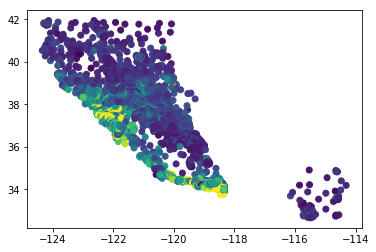

In [19]:
import matplotlib.pyplot as plt
plt.scatter(d_train["fold4"][d_train["fold4"]["synth"]==0]["longitude"],d_train["fold4"][d_train["fold4"]["synth"]==0]["latitude"],c=d_train["fold4"][d_train["fold4"]["synth"]==0]["median_house_value"])

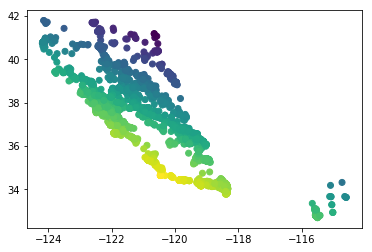

In [20]:
plt.scatter(d_train["fold4"][d_train["fold4"]["synth"]==1]["longitude"],d_train["fold4"][d_train["fold4"]["synth"]==1]["latitude"],c=d_train["fold4"][d_train["fold4"]["synth"]==1]["median_house_value"])

In [18]:
d_train["fold4"]

,households,housing_median_age,id,latitude,longitude,median_house_value,median_income,ocean_proximity,population,synth,total_bedrooms,total_rooms
0,126.000000,41.000000,0,37.880000,-122.230000,452600.000000,8.325200,NEAR BAY,322.000000,0,129.000000,880.000000
1,1138.000000,21.000000,1,37.860000,-122.220000,358500.000000,8.301400,NEAR BAY,2401.000000,0,1106.000000,7099.000000
2,177.000000,52.000000,2,37.850000,-122.240000,352100.000000,7.257400,NEAR BAY,496.000000,0,190.000000,1467.000000
3,219.000000,52.000000,3,37.850000,-122.250000,341300.000000,5.643100,NEAR BAY,558.000000,0,235.000000,1274.000000
4,259.000000,52.000000,4,37.850000,-122.250000,342200.000000,3.846200,NEAR BAY,565.000000,0,280.000000,1627.000000
5,193.000000,52.000000,5,37.850000,-122.250000,269700.000000,4.036800,NEAR BAY,413.000000,0,213.000000,919.000000
6,514.000000,52.000000,6,37.840000,-122.250000,299200.000000,3.659100,NEAR BAY,1094.000000,0,489.000000,2535.000000
7,647.000000,52.000000,7,37.840000,-122.250000,241400.000000,3.120000,NEAR BAY,1157.000000,0,687.000000,3104.000000
8,595.000000,42.000000,8,37.840000,-122.260000,226700.000000,2.080400,NEAR BAY,1206.000000,0,665.000000,2555.000000
9,714.000000,52.000000,9,37.840000,-122.250000,261100.000000,3.691200,NEAR BAY,1551.000000,0,707.000000,3549.000000
